In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import math
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

Running on cpu


In [46]:
df = pd.read_csv("essays.csv")

In [7]:
vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    stop_words='english'
)

X = vectorizer.fit_transform(df['essay']).astype("float32")

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X, df['prompt'], test_size=.2)
print(y_train.value_counts())
print(y_val.value_counts())

prompt
3    413
1    400
4    398
5    396
2    393
Name: count, dtype: int64
prompt
2    107
5    104
4    102
1    100
3     87
Name: count, dtype: int64


In [31]:
class EssayBaseDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.toarray())
        self.y = (torch.tensor(y) - 1).long()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [13]:
class BaseClassifier(nn.Module):
    def __init__(self, input_dim, num_labels=5):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels)
        )

    def forward(self, x):
        return self.classifier(x)

In [33]:
train_data = EssayBaseDataset(X_train, y_train.values.tolist())
val_data = EssayBaseDataset(X_val, y_val.values.tolist())

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [35]:
# Function to quickly plot loss, accuracy, and other data
def plot_data(x, y, x_label: str, y_label: str, title: str):
  plt.plot(x, y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.show()

In [36]:
# Validation Function
@torch.no_grad()
def validation(net, val_loader):
    net.eval() # Set model to evaluation mode
    total_losses = 0
    total_correct_predictions = 0
    total_samples = 0

    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)

        y_hat = net(x)
        loss = F.cross_entropy(y_hat, y)
        # Accumulate weighted by batch size for correct average loss over all samples
        total_losses += loss.item() * y.size(0)

        predicted_classes = torch.argmax(y_hat, dim=1)
        total_correct_predictions += (predicted_classes == y).sum().item()
        total_samples += y.size(0)

    avg_loss = total_losses / total_samples
    avg_accuracy = 100 * total_correct_predictions / total_samples

    return avg_loss, avg_accuracy

In [42]:
def train(model, optimizer, train_loader, val_loader, epochs):
  train_accs, val_accs, train_losses, val_losses = [], [], [], []

  for epoch in range(epochs):
    epoch_loss = 0
    total_train_correct = 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch}"):
      model.train()
      x = x.to(device)
      y = y.to(device)

      y_hat = model(x)

      loss = nn.CrossEntropyLoss()(y_hat, y)
      epoch_loss += loss.item()

      preds = torch.argmax(y_hat, dim=1)
      total_train_correct += (preds == y).sum().item()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    val_loss, val_acc = validation(model, val_loader)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    train_acc = 100 * total_train_correct / len(train_loader.dataset)
    train_accs.append(train_acc)
    print(f"Epoch {epoch}: train_loss: {avg_loss} train_acc: {train_acc} val_loss: {val_loss} val_acc: {val_acc}")
  return train_losses, train_accs, val_losses, val_accs


In [43]:
net = BaseClassifier(input_dim=X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
train_losses, train_accs, val_losses, val_accs = train(net, optimizer, train_loader, val_loader, 10)

Epoch 0: 100%|██████████| 63/63 [00:06<00:00, 10.36it/s]


Epoch: 0 train_loss: 0.6086800768971443 train_acc: 96.95 val_loss: 0.03742973965406418 val_acc: 100.0


Epoch 1: 100%|██████████| 63/63 [00:04<00:00, 14.27it/s]


Epoch: 1 train_loss: 0.01509916361805702 train_acc: 100.0 val_loss: 0.008309425853192807 val_acc: 100.0


Epoch 2: 100%|██████████| 63/63 [00:06<00:00,  9.99it/s]


Epoch: 2 train_loss: 0.0053837419642756386 train_acc: 100.0 val_loss: 0.004249985244125128 val_acc: 100.0


Epoch 3: 100%|██████████| 63/63 [00:07<00:00,  8.31it/s]


Epoch: 3 train_loss: 0.0029579755085121307 train_acc: 100.0 val_loss: 0.0025342017989605664 val_acc: 100.0


Epoch 4: 100%|██████████| 63/63 [00:05<00:00, 11.69it/s]


Epoch: 4 train_loss: 0.0018858263594290568 train_acc: 100.0 val_loss: 0.001686348938383162 val_acc: 100.0


Epoch 5: 100%|██████████| 63/63 [00:04<00:00, 13.89it/s]


Epoch: 5 train_loss: 0.0012701102079720134 train_acc: 100.0 val_loss: 0.0012292807595804334 val_acc: 100.0


Epoch 6: 100%|██████████| 63/63 [00:04<00:00, 14.04it/s]


Epoch: 6 train_loss: 0.0009709834934227051 train_acc: 100.0 val_loss: 0.0009429184524342418 val_acc: 100.0


Epoch 7: 100%|██████████| 63/63 [00:05<00:00, 12.39it/s]


Epoch: 7 train_loss: 0.000768820212836126 train_acc: 100.0 val_loss: 0.0007461376818828284 val_acc: 100.0


Epoch 8: 100%|██████████| 63/63 [00:04<00:00, 14.20it/s]


Epoch: 8 train_loss: 0.0006523624183573124 train_acc: 100.0 val_loss: 0.0006114059896208346 val_acc: 100.0


Epoch 9: 100%|██████████| 63/63 [00:04<00:00, 12.68it/s]


Epoch: 9 train_loss: 0.0005189341091964808 train_acc: 100.0 val_loss: 0.0005127827706746757 val_acc: 100.0


In [45]:
print(X_train.shape[1])

20000


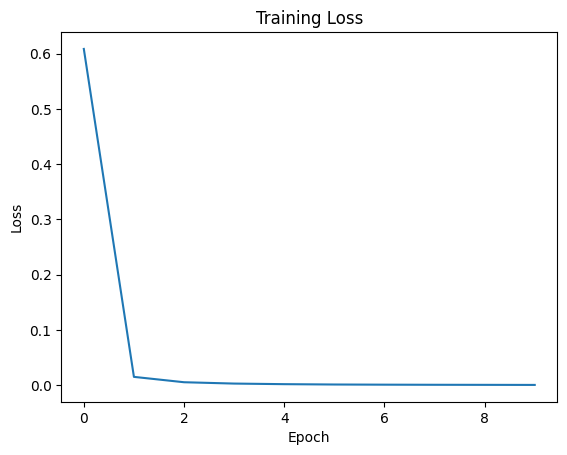

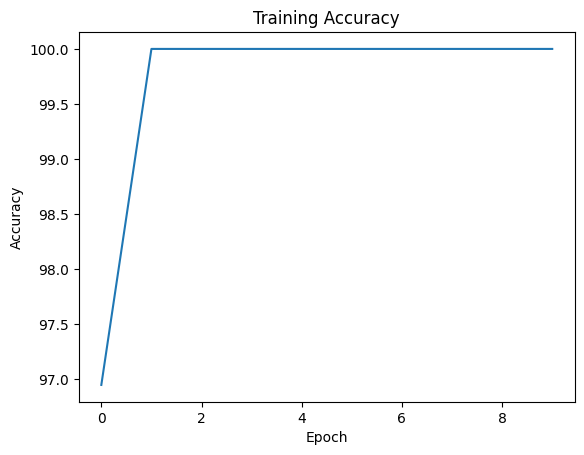

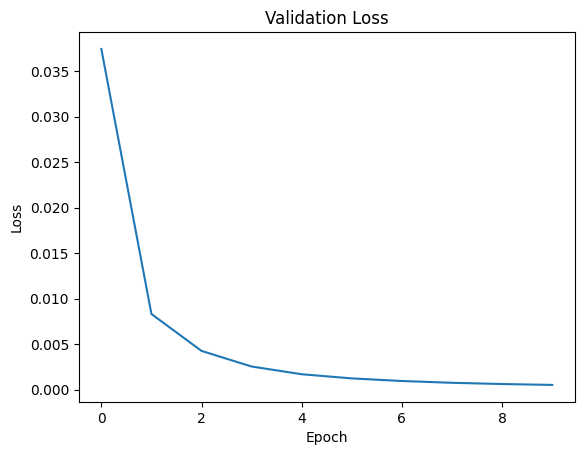

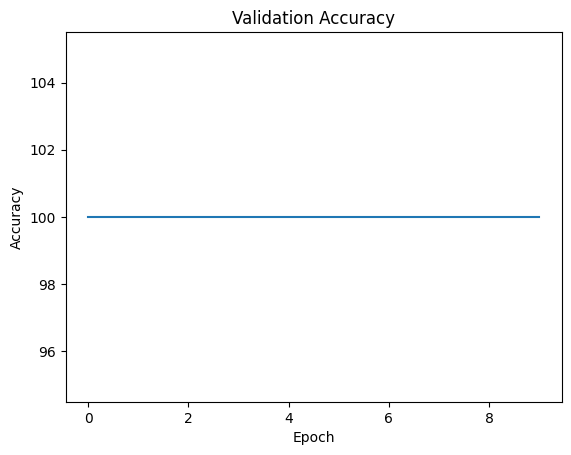

In [44]:
plot_data(range(len(train_losses)), train_losses, "Epoch", "Loss", "Training Loss")
plot_data(range(len(train_accs)), train_accs, "Epoch", "Accuracy", "Training Accuracy")
plot_data(range(len(val_losses)), val_losses, "Epoch", "Loss", "Validation Loss")
plot_data(range(len(val_accs)), val_accs, "Epoch", "Accuracy", "Validation Accuracy")

That trained so well, it had 100% accuracy on the first epoch validaiton. 2 Epochs gave it 100% on the training set too. Despite this, training time was quite fast. It only took 1 minute.